# SVM sur des données fonctionnelles 

## Octane data

https://cran.r-project.org/web/packages/fds/fds.pdf section Octane

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.interpolate import UnivariateSpline

%matplotlib inline

In [77]:
x = pd.read_csv('x.csv', squeeze=True, index_col=0)
y = pd.read_csv('y.csv', index_col=0)
raw_cible = pd.read_csv('cible.csv', squeeze=True, index_col=0)
cible = raw_cible.copy()
df = y.transpose()
df.shape #60, 401)
df.head()

,900,902,904,906,908,910,912,914,916,918,...,1682,1684,1686,1688,1690,1692,1694,1696,1698,1700
1,-0.0502,-0.0459,-0.0422,-0.0372,-0.0333,-0.0312,-0.0300,-0.0313,-0.0342,-0.0360,...,1.20,1.22,1.24,1.25,1.25,1.25,1.26,1.24,1.25,1.22
2,-0.0442,-0.0396,-0.0357,-0.0309,-0.0267,-0.0239,-0.0226,-0.0254,-0.0290,-0.0327,...,1.13,1.15,1.19,1.22,1.25,1.28,1.22,1.23,1.23,1.20
3,-0.0469,-0.0413,-0.0370,-0.0315,-0.0265,-0.0233,-0.0214,-0.0250,-0.0293,-0.0339,...,1.15,1.17,1.20,1.24,1.26,1.28,1.22,1.22,1.23,1.21
4,-0.0467,-0.0422,-0.0386,-0.0345,-0.0302,-0.0277,-0.0260,-0.0283,-0.0309,-0.0340,...,1.16,1.17,1.20,1.23,1.26,1.27,1.21,1.22,1.23,1.21
5,-0.0509,-0.0451,-0.0410,-0.0364,-0.0327,-0.0315,-0.0314,-0.0346,-0.0378,-0.0408,...,1.25,1.24,1.26,1.27,1.30,1.30,1.23,1.23,1.23,1.20


On prend arbitrairement une valeur seuil : 87, pour se ramener à un problème de classification

In [78]:
seuil = 87
cible.loc[cible < seuil] = 0
cible.loc[cible >= seuil] = 1

## Modèle de base : KNN, SVM sur les données brutes

L'idée est d'évaluer les performances pour les modèles de base sur les données brutes, pour ensuite comparer avec un SVM dont le noyau prend en compte la spécificité des données fonctionnelles.

In [119]:
#KNN repeated CV
scores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(df, cible, train_size=0.7)
    knn_clf.fit(X_train, y_train)
    scores.append(knn_clf.score(X_test, y_test))
print('KNN : mean Accuracy {:.5f} (500 CV)'.format(np.mean(scores))) 

KNN : mean Accuracy 0.81811 (500 CV)


In [126]:
#SVM repeated CV 
#Kernel Linear
scores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(df, cible, train_size=0.7)
    base_svm = SVC(kernel='linear', gamma='scale', C=1)
    base_svm.fit(X_train, y_train)
    scores.append(base_svm.score(X_test, y_test))
print('SVM : mean Accuracy {:.5f} (500 CV)'.format(np.mean(scores))) 

SVM : mean Accuracy 0.62989 (500 CV)


In [127]:
#SVM repeated CV 
#Kernel rbf
scores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(df, cible, train_size=0.7)
    base_svm = SVC(kernel='rbf', gamma='scale', C=1)
    base_svm.fit(X_train, y_train)
    scores.append(base_svm.score(X_test, y_test))
print('SVM : mean Accuracy {:.5f} (500 CV)'.format(np.mean(scores))) 

SVM : mean Accuracy 0.63211 (500 CV)


Mauvaises performances du SVM sur les données brutes


## SVM après dérivées secondes 

https://stackoverflow.com/questions/40226357/second-derivative-in-python-scipy-numpy-pandas

**EXEMPLE POUR UN INDIVIDU**

''

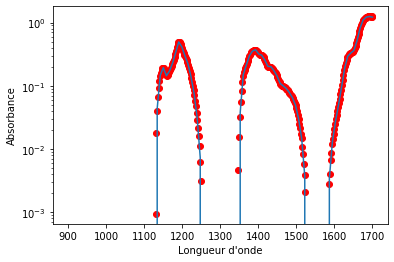

In [173]:
#Exemple d'interpolation pour un individu
x_bis = np.array(x)
y_bis = np.array(y.iloc[:,0])
y_spl = UnivariateSpline(x_bis,y_bis,s=0,k=4)
plt.semilogy(x_bis,y_bis,'ro',label = 'data')
x_range = np.linspace(x_bis[0],x_bis[-1],100)
plt.semilogy(x_range,y_spl(x_range))
plt.xlabel('Longueur d\'onde')
plt.ylabel('Absorbance')
plt.savefig('pre_fig3.png')
;


''

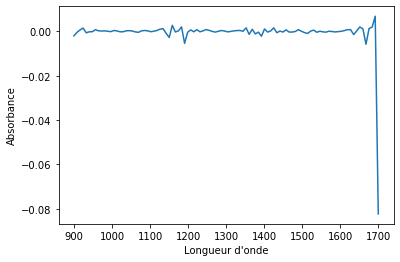

In [174]:
#Exemple d'une dérivée seconde pour un individu
y_spl_2d = y_spl.derivative(n=2)
plt.plot(x_range,y_spl_2d(x_range));
plt.savefig('derivation.png')
plt.xlabel('Longueur d\'onde')
plt.ylabel('Absorbance')
plt.savefig('pre_fig4.png')
; 

**POUR TOUS LES INDIVIDUS**

In [84]:
idx_1 = cible.loc[cible == 1].index-1

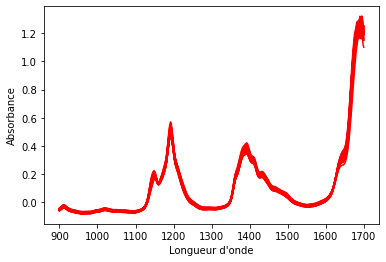

In [176]:
fig, ax = plt.subplots()
for i in idx_1:
    plt.plot(x, df.iloc[i,:], 'r')
#ax.set_title('résistant à l\'auto allumage (1)')
ax.set_xlabel('Longueur d\'onde')
ax.set_ylabel('Absorbance')
fig.savefig('c_1.png');

In [86]:
#On créer une fonction dérivée seconde 
def sd_derivative(x, y, n=100):
    y_spl = UnivariateSpline(x,y,s=0,k=4)
    #x_range = np.linspace(x[0],x[-1],n)
    y_spl_2d = y_spl.derivative(n=2)
    return(y_spl_2d(x_range))

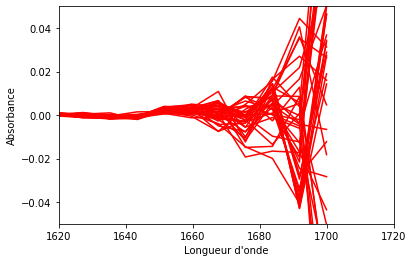

In [177]:
#On l'applique à tous les individus de la classe 1
fig, ax = plt.subplots()

for i in idx_1:
    y_bis = np.array(y.iloc[:,i])
    plt.plot(x_range,sd_derivative(x_bis, y_bis), 'r')
#ax.set_title('Dérivée seconde : résistant à l\'auto allumage (1)')
ax.set_xlabel('Longueur d\'onde')
ax.set_ylabel('Absorbance')
ax.set_xlim((1620, 1720))
ax.set_ylim(-0.05, 0.05)
fig.savefig('sd_1.png');

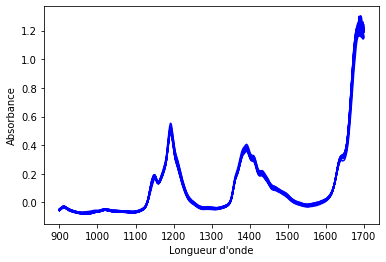

In [178]:
idx_0 = cible.loc[cible == 0].index-1
fig, ax = plt.subplots()
for i in idx_0:
    plt.plot(x, df.iloc[i,:], 'b')
#ax.set_title('non résistant à l\'auto allumage (0)')
ax.set_xlabel('Longueur d\'onde')
ax.set_ylabel('Absorbance')
fig.savefig('c_0.png');

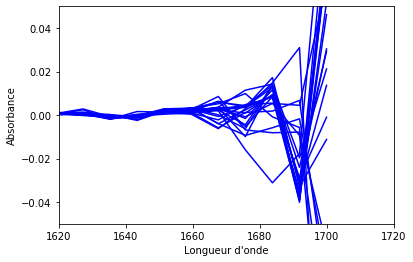

In [179]:

#On l'applique à tous les individus de la classe 0
fig, ax = plt.subplots()

for i in idx_0:
    y_bis = np.array(y.iloc[:,i])
    plt.plot(x_range,sd_derivative(x_bis, y_bis), 'b')
#ax.set_title('Dérivée seconde : non résistant à l\'auto allumage (0)')
ax.set_xlabel('Longueur d\'onde')
ax.set_ylabel('Absorbance')
ax.set_xlim((1620, 1720))
ax.set_ylim(-0.05, 0.05)
fig.savefig('sd_0.png');

In [90]:
#On reforme un dataframe
df_sdD = pd.DataFrame([sd_derivative(x_bis, np.array(y.iloc[:,i])) for i in np.arange(60)], columns = np.arange(1,101))
#Cross validation 
X_train, X_test, y_train, y_test = train_test_split(df_sdD, cible, train_size=0.7)

In [130]:
#SVM sur les dérivées secondes 
#Kernel : linear
scores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(df_sdD, cible, train_size=0.7)
    base_svm = SVC(kernel='linear', gamma='scale', C=1)
    base_svm.fit(X_train, y_train)
    scores.append(base_svm.score(X_test, y_test))
print('SVM : mean Accuracy {:.5f} (500 CV), sur dérivées secondes'.format(np.mean(scores))) 

SVM : mean Accuracy 0.64167 (500 CV), sur dérivées secondes


On obtient notre meilleur score ! 

In [129]:
#Kernel : RBF
scores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(df_sdD, cible, train_size=0.7)
    base_svm = SVC(kernel='rbf', gamma='scale', C=1)
    base_svm.fit(X_train, y_train)
    scores.append(base_svm.score(X_test, y_test))
print('SVM : mean Accuracy {:.5f} (500 CV), sur dérivées secondes'.format(np.mean(scores))) 

SVM : mean Accuracy 0.59722 (500 CV), sur dérivées secondes
